In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import pydicom
import cv2
import PIL
import matplotlib.pyplot as plt
import pandas as pd
import os
from showimage import ShowImage

In [116]:
path = ('D:/Uni/mri/SK_MRI/MS_dataset_full/MS/')

In [340]:
img = cv2.imread(path + '01_1/IM000011.png',3) #read img
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) #convert to grayscale

# Baseline

In [308]:
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)
ret, markers = cv2.connectedComponents(thresh)

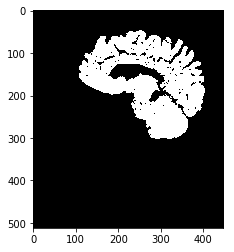

In [309]:
#Get the area taken by each component. Ignore label 0 since this is the background.
marker_area = [np.sum(markers == m) for m in range(np.max(markers)) if m != 0] 

#Get label of largest component by area
largest_component = np.argmax(marker_area) + 1 #Add 1 since we dropped zero above                        

#Get pixels which correspond to the brain
brain_mask = markers == largest_component
plt.imshow(brain_mask, cmap = 'gray')

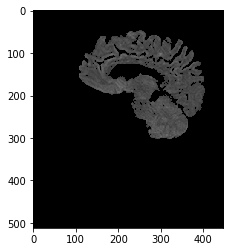

In [310]:
brain_out = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out[brain_mask == False] = (0,0,0)
plt.imshow(brain_out)

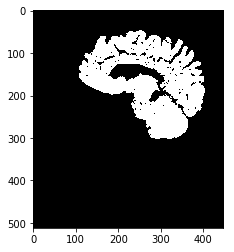

In [311]:
brain_mask = np.uint8(brain_mask)
#kernel = np.ones((5,5),np.uint8)
#closing = cv2.morphologyEx(brain_mask, cv2.MORPH_CLOSE, kernel)
plt.imshow(brain_mask, cmap = 'gray')

In [313]:
im_floodfill = brain_mask.copy()
     
# Mask used to flood filling.
# Notice the size needs to be 2 pixels > than the image.
h, w = closing.shape[:2]
mask = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(im_floodfill, mask, (0,0), 255);
# Invert floodfilled image
im_floodfill_inv = cv2.bitwise_not(im_floodfill)

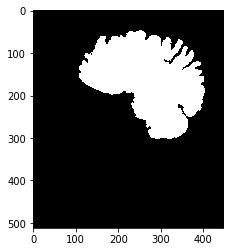

In [315]:
# Combine the two images to get the foreground.
im_out = brain_mask | im_floodfill_inv 
plt.imshow(im_out, cmap = 'gray')

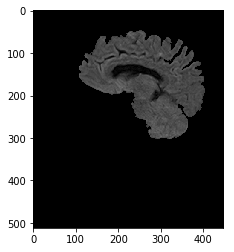

In [316]:
brain_out = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out[im_out == False] = (0,0,0)
plt.imshow(brain_out, cmap = 'gray')

# Baseline + Tophat

In [181]:
#edgedImage = cv2.bitwise_not(brain_mask).copy()
#_, contours, _ = cv2.findContours(edgedImage, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#cv2.drawContours(edgedImage,contours,-1,(255,255,255),1)
#edgedImage = cv2.bitwise_not(edgedImage)
#plt.imshow(edgedImage)

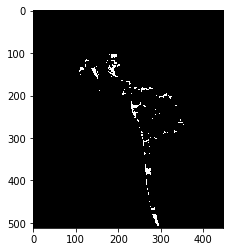

In [182]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10, 10))
tophat = cv2.morphologyEx(brain_mask, cv2.MORPH_TOPHAT, kernel)

plt.imshow(tophat, cmap = 'gray')

In [183]:
#thresh = cv2.threshold(tophat, 200, 255, cv2.THRESH_BINARY)[1]
#thresh2 = thresh.copy()
#_, contours,_ = cv2.findContours(thresh2,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
#cv2.drawContours(thresh2,contours,-1,(255,255,255),1)
#plt.imshow(thresh, cmap = 'gray')

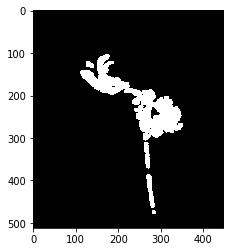

In [184]:
disconnect = brain_mask - tophat
plt.imshow(disconnect, cmap = 'gray')

In [185]:
#nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(test, connectivity=8)
#sizes = stats[1:, -1]; nb_components = nb_components - 1
#min_size = h * w *0.08
#theone = np.zeros((test.shape))
#for i in range(0, nb_components):
#    if sizes[i] >= 1:
#        theone[test == i + 1] = 255  
#theone = theone.astype(np.uint8)
#plt.imshow(theone)

In [186]:
ret, markers = cv2.connectedComponents(disconnect)

marker_area = [np.sum(markers == m) for m in range(np.max(markers)) if m != 0] 

largest_component = np.argmax(marker_area) + 1 
new_mask = markers == largest_component
plt.imshow(new_mask, cmap = 'gray')

In [189]:
details = new_mask + tophat
#plt.imshow(details, cmap = 'gray')

In [190]:
ret, markers = cv2.connectedComponents(details)
marker_area = [np.sum(markers == m) for m in range(np.max(markers)) if m != 0] 
largest_component = np.argmax(marker_area) + 1 
clean = markers == largest_component
#plt.imshow(clean, cmap = 'gray')

In [191]:
clean = np.uint8(clean)

# Floodfill from point (0, 0)
im_floodfill_1 = clean.copy()
h, w = clean.shape[:2]

mask_1 = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(im_floodfill_1, mask_1, (0,0), 255);

# Invert floodfilled image
im_floodfill_inv_1 = cv2.bitwise_not(im_floodfill_1)
#plt.imshow(im_floodfill_inv_1, cmap = 'gray')

In [192]:
# Combine the two images to get the foreground.
finalmask = clean | im_floodfill_inv_1

In [193]:
finalbrain = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
finalbrain[finalmask == False] = (0,0,0)
#plt.imshow(finalbrain)

(Text(0.5,1,'Mask image'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

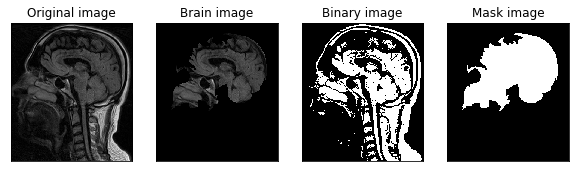

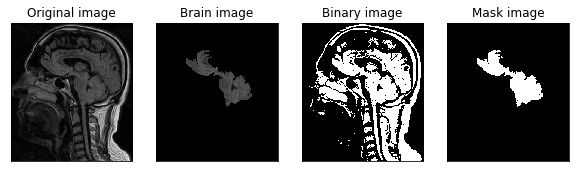

In [194]:
plt.figure(figsize=(10, 10))
plt.subplot(241),plt.imshow(img)
plt.title('Original image'), plt.xticks([]), plt.yticks([])
plt.subplot(242),plt.imshow(brain_out)
plt.title('Brain image'), plt.xticks([]), plt.yticks([])
plt.subplot(243),plt.imshow(thresh,cmap = 'gray')
plt.title('Binary image'), plt.xticks([]), plt.yticks([])
plt.subplot(244),plt.imshow(im_out, cmap = 'gray')
plt.title('Mask image'),  plt.xticks([]), plt.yticks([])

plt.figure(figsize=(10, 10))
plt.subplot(241),plt.imshow(img)
plt.title('Original image'), plt.xticks([]), plt.yticks([])
plt.subplot(242),plt.imshow(finalbrain)
plt.title('Brain image'), plt.xticks([]), plt.yticks([])
plt.subplot(243),plt.imshow(thresh,cmap = 'gray')
plt.title('Binary image'), plt.xticks([]), plt.yticks([])
plt.subplot(244),plt.imshow(finalmask, cmap = 'gray')
plt.title('Mask image'),  plt.xticks([]), plt.yticks([])

# Invert the empty space

In [197]:
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_OTSU)

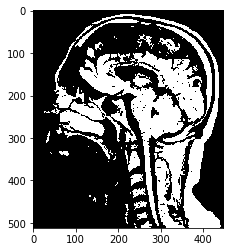

In [199]:
plt.imshow(thresh,cmap = 'gray')

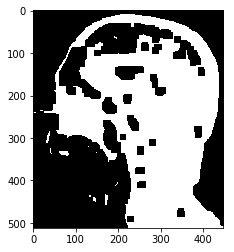

In [206]:
thresh = np.uint8(thresh)
kernel = np.ones((15,15),np.uint8)
closing = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing, cmap = 'gray')

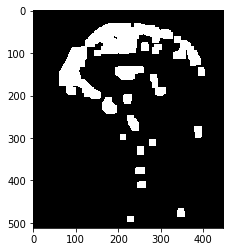

In [211]:
closing = np.uint8(closing)

# Floodfill from point (0, 0)
im_floodfill_2 = closing.copy()
h, w = closing.shape[:2]

mask_2 = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(im_floodfill_2, mask_2, (0,0), 255);

# Invert floodfilled image
im_floodfill_inv_2 = cv2.bitwise_not(im_floodfill_2)
plt.imshow(im_floodfill_inv_2, cmap = 'gray')

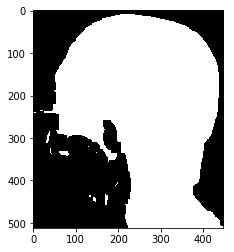

In [213]:
fullmask = closing | im_floodfill_inv_2
plt.imshow(fullmask, cmap = 'gray')

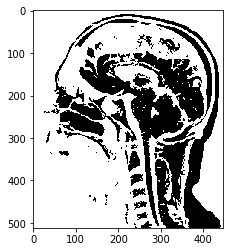

In [218]:
#fullmask = np.uint8(fullmask)
maskedmask = cv2.bitwise_not(thresh).copy()
plt.imshow(maskedmask, cmap = 'gray')

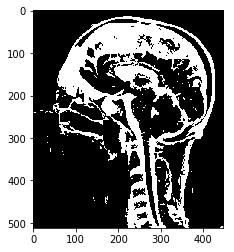

In [220]:
#In a copy of the original image, clear those pixels that don't correspond to the brain
maskedmask[fullmask == False] = 0
plt.imshow(maskedmask, cmap = 'gray')

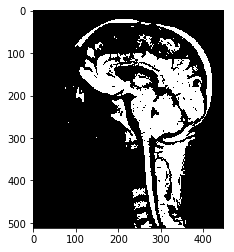

In [222]:
maskedmask = np.uint8(maskedmask)

# Floodfill from point (0, 0)
im_floodfill_3 = maskedmask.copy()
h, w = maskedmask.shape[:2]

mask_3 = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(im_floodfill_3, mask_3, (0,0), 255);

# Invert floodfilled image
im_floodfill_inv_3 = cv2.bitwise_not(im_floodfill_3)
plt.imshow(im_floodfill_inv_3, cmap = 'gray')

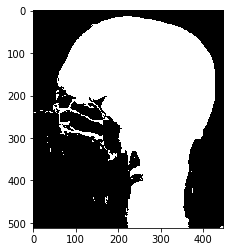

In [224]:
fullmask_1 = maskedmask | im_floodfill_inv_3
plt.imshow(fullmask_1, cmap = 'gray')

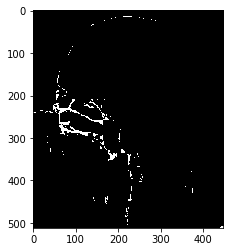

In [225]:
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10, 10))
tophat_1 = cv2.morphologyEx(fullmask_1, cv2.MORPH_TOPHAT, kernel)

plt.imshow(tophat_1, cmap = 'gray')

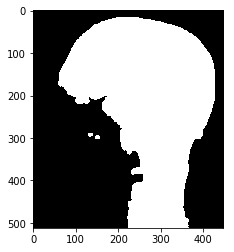

In [226]:
clean_1 = fullmask_1 - tophat_1
plt.imshow(clean_1, cmap = 'gray')

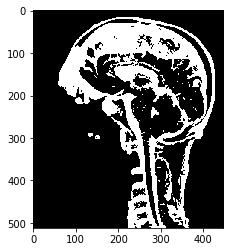

In [227]:
#In a copy of the original image, clear those pixels that don't correspond to the brain
maskedmask_1 = maskedmask.copy()
maskedmask_1[clean_1 == False] = 0
plt.imshow(maskedmask_1, cmap = 'gray')

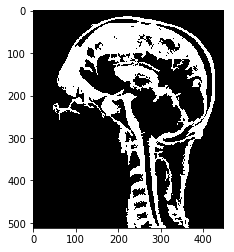

In [335]:
ret, markers = cv2.connectedComponents(maskedmask)

marker_area = [np.sum(markers == m) for m in range(np.max(markers)) if m != 0] 

largest_component_1 = np.argmax(marker_area) + 1 
new_mask_1 = markers == largest_component_1
plt.imshow(new_mask_1, cmap = 'gray')

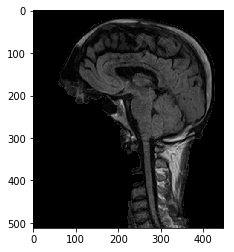

In [231]:
finalbrain_1 = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
finalbrain_1[new_mask_1 == False] = (0,0,0)
plt.imshow(finalbrain_1)

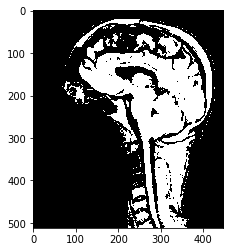

In [287]:
gray_1 = cv2.cvtColor(finalbrain_1, cv2.COLOR_BGR2GRAY)
ret, thresh_1 = cv2.threshold(gray_1,0,255,cv2.THRESH_OTSU)
ret, markers_1 = cv2.connectedComponents(thresh_1)
plt.imshow(thresh_1, cmap = 'gray')

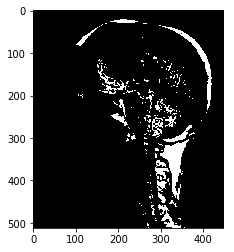

In [279]:
exp1 = gray_1.copy()
exp2 = exp1 > 80
plt.imshow(exp2,cmap = 'gray')

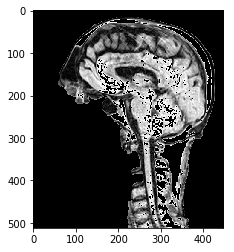

In [281]:
#exp1 = np.uint8(exp1)
exp1[exp2 == True] = 0
plt.imshow(exp1, cmap = 'gray')

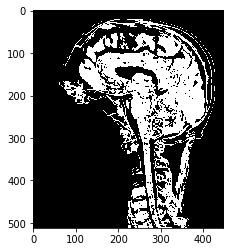

In [292]:
# exp1 = np.uint8(exp1)
# gray_2 = cv2.cvtColor(exp1, cv2.COLOR_BGR2GRAY)
ret, thresh_2 = cv2.threshold(exp1,0,255,cv2.THRESH_OTSU)
ret, markers_2 = cv2.connectedComponents(thresh_2)
plt.imshow(thresh_2, cmap = 'gray')

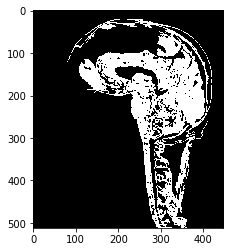

In [293]:
## Get the area taken by each component. Ignore label 0 since this is the background.
marker_area_1 = [np.sum(markers_2 == m) for m in range(np.max(markers_2)) if m != 0] 

#Get label of largest component by area
largest_component_1 = np.argmax(marker_area_1) + 1 #Add 1 since we dropped zero above                        

#Get pixels which correspond to the brain
brain_mask_2 = markers_2 == largest_component_1
plt.imshow(brain_mask_2, cmap = 'gray')

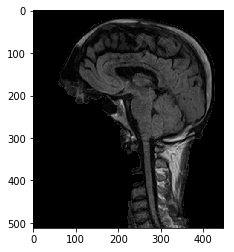

In [241]:
brain_out_1 = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out_1[brain_mask_2 == False] = (0,0,0)
plt.imshow(brain_out_1)

In [242]:
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thresh_1, connectivity=8)
sizes = stats[1:, -1]; nb_components = nb_components - 1
min_size = h*w*0.08

In [243]:
img_1 = np.zeros((output.shape))
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img_1[output == i + 1] = 255

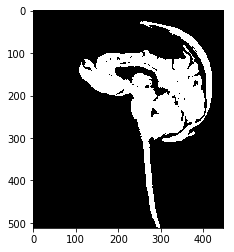

In [245]:
plt.imshow(img_1, cmap = 'gray')

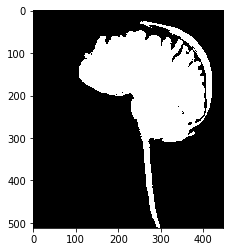

In [317]:
img_1 = np.uint8(img_1)
lol = img_1 | im_out
plt.imshow(lol, cmap = 'gray')

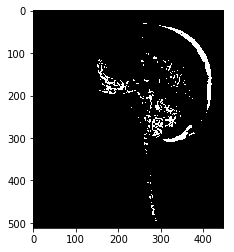

In [342]:
brain_out_2 = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out_2[lol == False] = (0,0,0)
gray_3 = cv2.cvtColor(brain_out_2, cv2.COLOR_BGR2GRAY)
exp3 = gray_3 > 80
plt.imshow(exp3, cmap = 'gray')

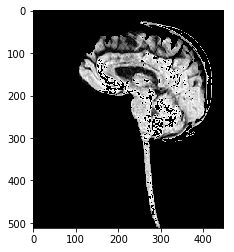

In [343]:
gray_3[exp3 == True] = 0
plt.imshow(gray_3, cmap = 'gray')

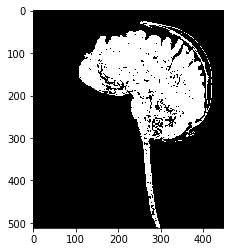

In [344]:
gray_3[gray_3 > 0] = 255
plt.imshow(gray_3, cmap = 'gray')

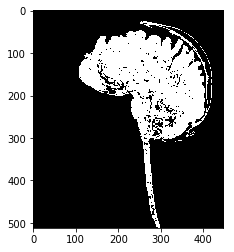

In [345]:
nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(gray_3, connectivity=8)
sizes = stats[1:, -1]; nb_components = nb_components - 1
min_size = h*w*0.08
img_1 = np.zeros((output.shape))
for i in range(0, nb_components):
    if sizes[i] >= min_size:
        img_1[output == i + 1] = 255
plt.imshow(img_1, cmap = 'gray')

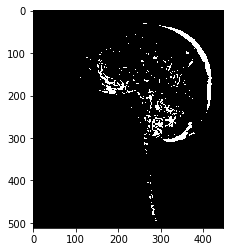

In [346]:
img_1 = np.uint8(img_1)

# Floodfill from point (0, 0)
im_floodfill_4 = img_1.copy()
h, w = img_1.shape[:2]

mask_4 = np.zeros((h+2, w+2), np.uint8)
cv2.floodFill(im_floodfill_4, mask_4, (0,0), 255);

# Invert floodfilled image
im_floodfill_inv_4 = cv2.bitwise_not(im_floodfill_4)
plt.imshow(im_floodfill_inv_4, cmap = 'gray')

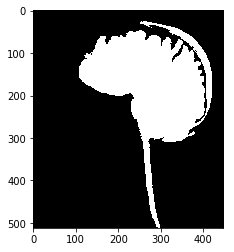

In [347]:
fullmask_3 = img_1 | im_floodfill_inv_4
plt.imshow(fullmask_3, cmap = 'gray')

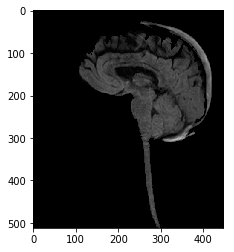

In [348]:
brain_out_3 = img.copy()
#In a copy of the original image, clear those pixels that don't correspond to the brain
brain_out_3[fullmask_3 == False] = (0,0,0)
plt.imshow(brain_out_3)